In [25]:
import numpy as np
import pandas as pd
import random

from dataclasses import dataclass

from simulation.domain.model import construct_well, h_lim, betta_G_lim
from simulation.service_layer.services import get_dict_for_data, build_plot, PlotData, Scale
from simulation.domain.meter import Meter, add_noise

In [26]:
# Начальные условия
M_q = 0.5
epsilon = 0.00001
K_NUMBERS = 45000  # Количество точек моделирования
dt = 0.0001  # Суток

In [27]:
# Задать seed для генерации случайных чисел
np.random.seed(5)
random.seed(5)

In [28]:
w_program = {2: 1.065556, 3: 0.9335, 3.7: 1}

well = construct_well()
well.set_w_program(w_program)


df = well.simulate(K_NUMBERS, dt, M_q, epsilon, get_dict_for_data())
df = pd.DataFrame(df)

In [29]:
#df.to_excel("model_output.xlsx")

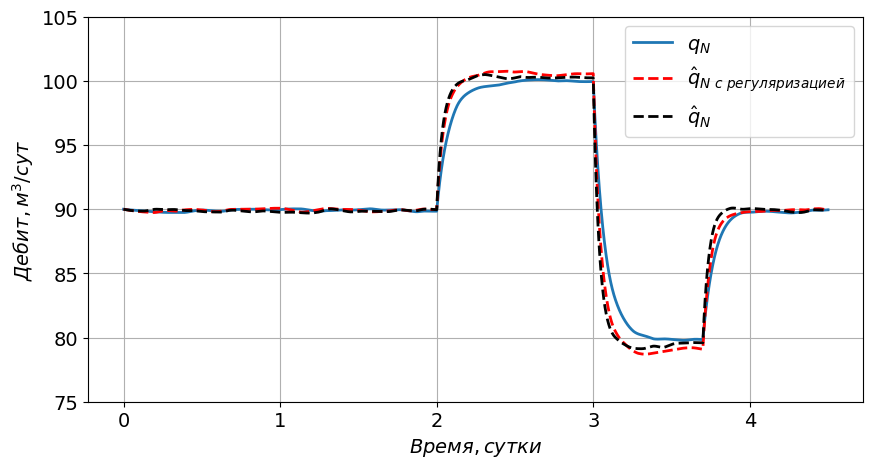

In [30]:
well1 = construct_well(w_1=(1/0.05), w_2=(1/0.025), p_R=19.43)
well1.set_w_program(w_program)

df1 = well1.simulate(K_NUMBERS, dt, M_q, epsilon, get_dict_for_data())
df1 = pd.DataFrame(df1)

well2 = construct_well(w_1=(1 / 0.04), w_2=(1 / 0.051), p_R=20.93)
well2.set_w_program(w_program)

df2 = well2.simulate(K_NUMBERS, dt, M_q, epsilon, get_dict_for_data())
df2 = pd.DataFrame(df2)

plot_data = [
             {'data': (
                 PlotData(df['q'], '', 2, 'q_N'),
                 PlotData(df1['q'], 'r--', 2, '\hat q_{N\ с\ регуляризацией}'),
                 PlotData(df2['q'], 'k--', 2, '\hat q_{N}')
              ), 'x': df['x'], 'y_scale': Scale(min=75, max=105), 'dt': dt}


            ]

plot = build_plot(plot_data)
plot.ylabel('$Дебит, м^3/сут$')
plot.show()

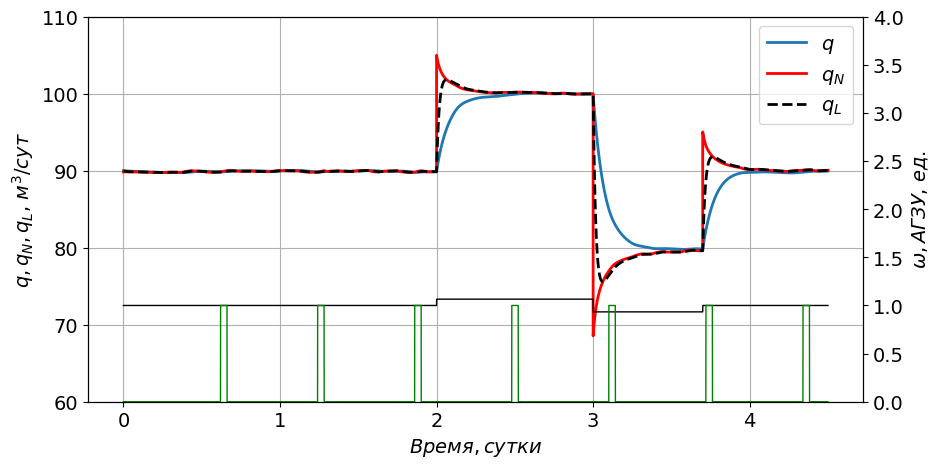

In [31]:
plot_data = [
             {'data': (
                PlotData(df['q'], '', 2, 'q'),
                PlotData(df['q_N'], 'r', 2, 'q_N'),
                PlotData(df['q_L'], 'k--', 2, 'q_L'),
              ), 'x': df['x'], 'y_scale': Scale(min=60, max=110), 'dt': dt, 'mu': 'м^3/сут'},
             {'data': (
               PlotData(df['u'], 'k', 1, '\omega'),
               PlotData(df['agzu'], 'g', 1, 'АГЗУ'),
              ), 'x': df['x'], 'y_scale': Scale(min=0, max=4), 'dt': dt, 'mu': 'ед.'},
            ]

plot = build_plot(plot_data)
plot.show()

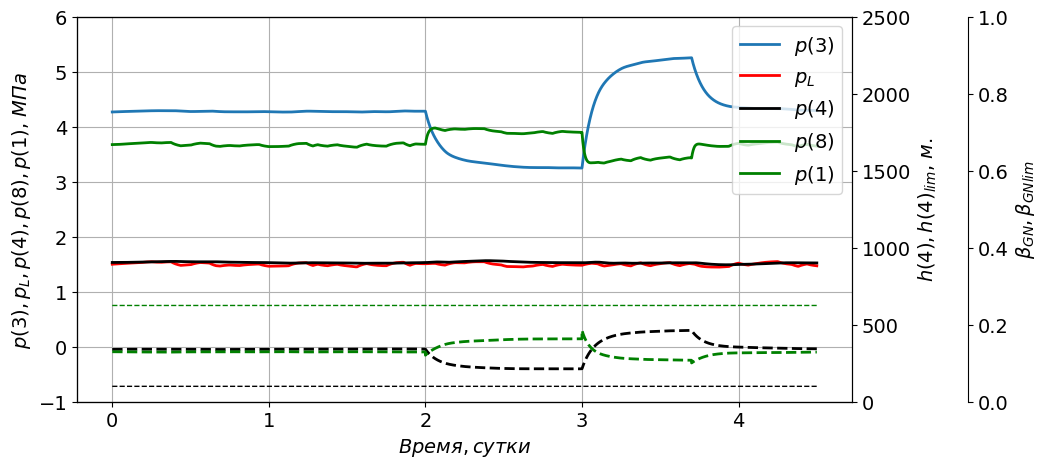

In [32]:
plot_data = [
            {'data': (
              PlotData(df['p_3'], '', 2, 'p(3)'),
              PlotData(df['p_L'], 'r', 2, 'p_L'),
              PlotData(df['p_4'], 'k', 2, 'p(4)'),
              PlotData(df['p_8'], 'g', 2, 'p(8)'),
              PlotData(df['p_1'], 'g', 2, 'p(1)'),
              ), 'x': df['x'], 'y_scale': Scale(min=-1, max=6), 'dt': dt, 'mu': 'МПа'},
            {'data': (
                PlotData(df['h_4'], 'k--', 2, 'h(4)'),
                PlotData(pd.Series([h_lim]*K_NUMBERS), 'k--', 1, 'h(4)_{lim}')
              ), 'x': df['x'], 'y_scale': Scale(min=0, max=2500), 'dt': dt, 'mu': 'м.'},
            {'data': (
                PlotData(df['betta_GN'], 'g--', 2, '\\beta_{GN}'),
                PlotData(pd.Series([betta_G_lim]*K_NUMBERS), 'g--', 1, '\\beta_{GNlim}')
              ), 'x': df['x'], 'y_scale':  Scale(min=0, max=1), 'dt': dt},
]


plot = build_plot(plot_data)
plot.show()

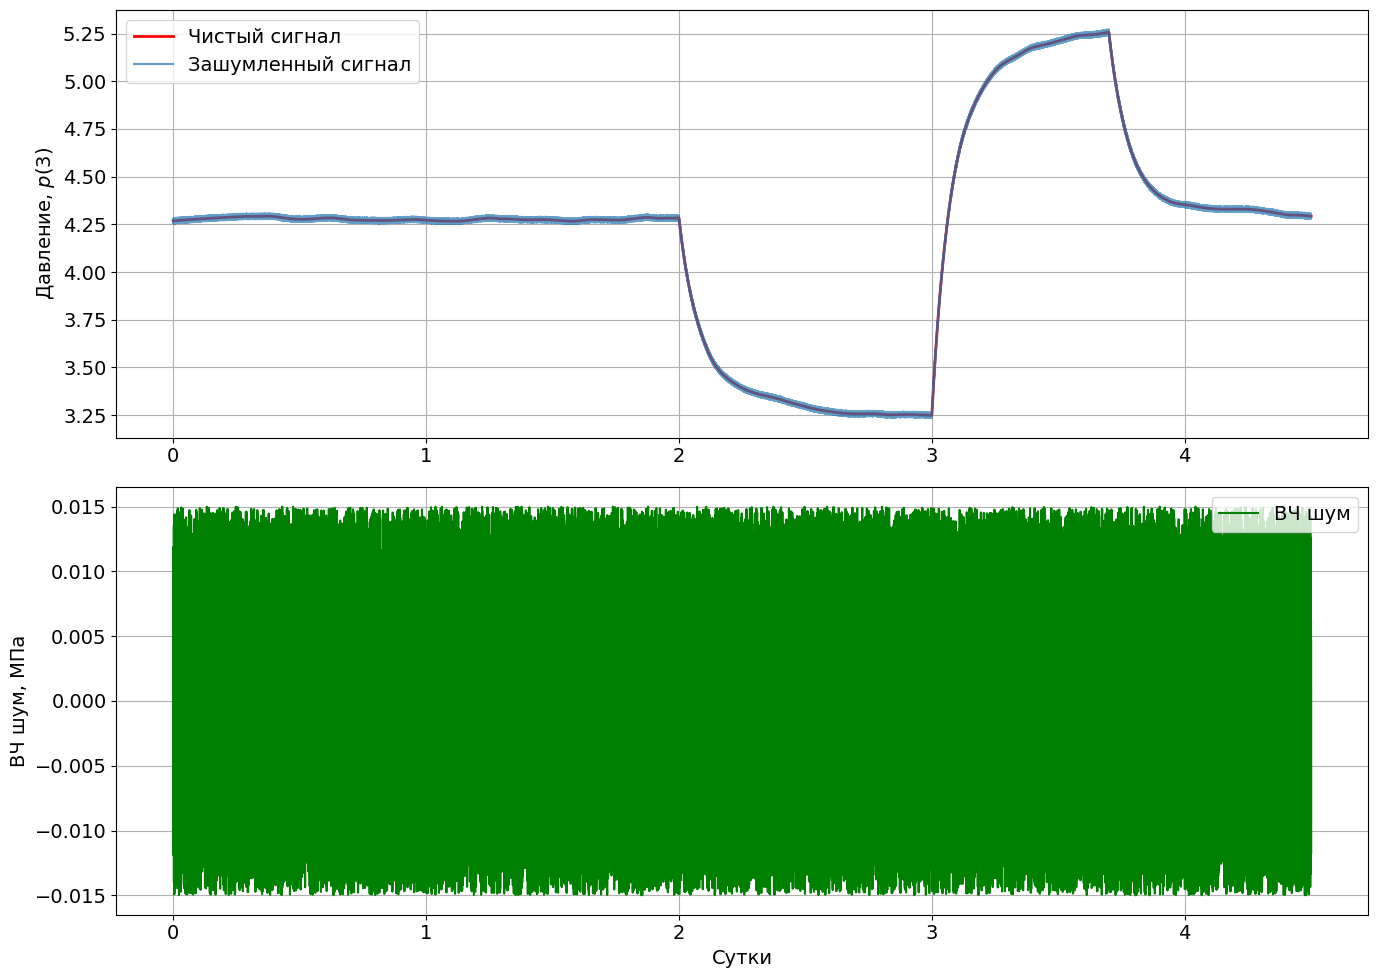

In [33]:
    from matplotlib import pyplot as plt
    # Добавление шумов
    clean_pressure = df['p_3']

    # Добавление шумов
    noisy_pressure, hf_noise = add_noise(clean_pressure, dt)

    # Визуализация
    plt.figure(figsize=(14, 10))

    # График давления
    plt.subplot(2, 1, 1)
    plt.plot(df['x'], clean_pressure, label='Чистый сигнал', color='r', lw=2)
    plt.plot(df['x'], noisy_pressure, label='Зашумленный сигнал', alpha=0.7)
    plt.ylabel('Давление, $p(3)$')

    plt.legend()
    plt.grid()

    # График ВЧ шума
    plt.subplot(2, 1, 2)
    plt.plot(df['x'], hf_noise, label='ВЧ шум', color='green')
    plt.ylabel('ВЧ шум, МПа')
    plt.xlabel('Сутки')
    plt.legend()
    plt.grid()


    plt.tight_layout()
    plt.show()

In [34]:
meter = Meter(dt)
meter.noise_enable = True
meter.noise_amplitude = 0.05
ident_dt, ident_k, df_ident = meter.measure(df, quant_step=None, denominator = 50)

In [36]:
df_ident.to_excel("model_measure.xlsx")

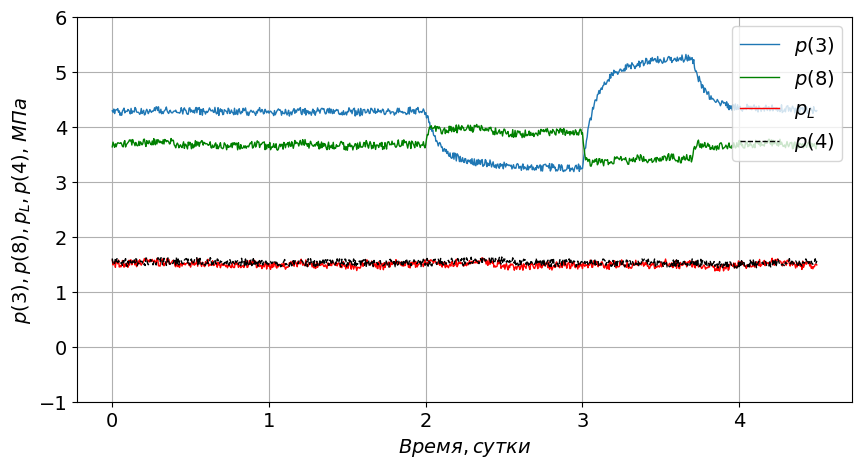

In [37]:
plot_data = [
            {'data': (
              PlotData(df_ident['p_3'], '', 1, 'p(3)'),
              PlotData(df_ident['p_8'], 'g', 1, 'p(8)'),
              PlotData(df_ident['p_L'], 'r', 1, 'p_L'),
              PlotData(df_ident['p_4'], 'k--', 1, 'p(4)'),
              ), 'x': df_ident['x'], 'y_scale': Scale(min=-1, max=6), 'dt': dt, 'mu': 'МПа'},
            ]

plot = build_plot(plot_data)
plot.show()

In [38]:
# Идентификация через фильтр

from dataclasses import dataclass, field
import scipy

from scipy.signal import medfilt


@dataclass
class CalculatedValues:
  values: list[float] = field(default_factory=list)

  def add(self, element):
    self.values.append(element)

def ident_values(ident_k, ident_dt, df_ident, well):
  calc_q_L = CalculatedValues()
  calc_dp = CalculatedValues()
  calc_dp_t = CalculatedValues()
  calc_q_t = CalculatedValues()
  calc_p_1_t = CalculatedValues()
  calc__q_t = CalculatedValues()

  for _k in range(ident_k):

    b_betta_L = well.b_0 - well.b_1*(well.params.p_G0 - df_ident['p_L'][_k])


    q_L = (b_betta_L/(well.oil.gamma*well.params.r_U))*(df_ident['p_8'][_k]-df_ident['p_L'][_k])

    dp = (df_ident['p_3'][_k]-df_ident['p_4'][_k])

    b_betta_3 = well.b_0 - well.params.alpha_G_3 * well.b_1 * (well.params.p_G0 - df_ident['p_3'][_k])

    if _k == 0:
      dp_t = dp
      b_betta_3_t = b_betta_3

    q_t = q_L + ((well.params.S_t/(well.oil.gamma*well.pump.t_N)) * (dp - dp_t))

    if _k == 0:
      _q_t = 90
      _p_3 = df_ident['p_3'][0]

    p_1_t = _p_3 + (well.oil.gamma/b_betta_3_t)*(well.params.H_R-well.pump.H_N+well.params.r_K*q_t)

    calc_q_L.add(q_L)
    calc_dp.add(dp)
    calc_dp_t.add(dp_t)
    calc_q_t.add(q_t)
    calc_p_1_t.add(p_1_t)
    calc__q_t.add(_q_t)

    dp_t = dp_t + (ident_dt/well.pump.t_N)*(dp - dp_t)
    _q_t = _q_t + (ident_dt/well.reservoir.T_2)*(q_t - _q_t)
    _p_3 = _p_3 + (ident_dt/well.pump.t_N)*(df_ident['p_3'][_k] - _p_3)
    b_betta_3_t = b_betta_3_t + (ident_dt/well.pump.t_N)*(b_betta_3 - b_betta_3_t)

  calc_df = pd.DataFrame({'q_L': calc_q_L.values,
                          'dp': calc_dp.values,
                          'dp_t': calc_dp_t.values,
                          'q_t': calc_q_t.values,
                          'p_1_t': calc_p_1_t.values,
                          '_q_t': calc__q_t.values,
                          })

  return calc_df

def identificate(calc_df, ident_k):
  X = np.array([[1 for _ in range(ident_k)],
              calc_df['q_t']*-1,
              calc_df['_q_t']*-1]).T
  y = np.array(calc_df['p_1_t']).T
  b, squared_error_sum, matrix_rank, SVD_ = scipy.linalg.lstsq(X, y)
  return b

def get_static_data(calc_df, ident_k, denominator, s_times):

  s_q_t = []
  s_p_t = []

  for start, end in s_times:
    start_index = int((start / dt) // denominator)
    end_index = int((end / dt) // denominator)

    s_q_t.append(calc_df['_q_t'][start_index:end_index])
    s_p_t.append(calc_df['p_1_t'][start_index:end_index])

  s_q_t = pd.concat(s_q_t)
  s_p_t = pd.concat(s_p_t)

  k_s = len(s_q_t)

  m2 = ident_k / k_s
  return s_q_t, s_p_t, m2, k_s

def identificate_regul(calc_df, ident_k, denominator, v_r, s_q_t, s_p_t, m2, k_s):

  # формируем и заполняем матрицу размерностью 2x2
  A1 = np.empty((3, 3))
  A1[[0], [0]] = len(calc_df)
  A1[[0], [1]] = -sum(calc_df['q_t'])
  A1[[0], [2]] = -sum(calc_df['_q_t'])

  A1[[1], [0]] = -sum(calc_df['q_t'])
  A1[[1], [1]] = sum([value**2 for value in calc_df['q_t']])
  A1[[1], [2]] = sum([calc_df['_q_t'][i]*calc_df['q_t'][i] for i in range(len(calc_df))])

  A1[[2], [0]] = -sum(calc_df['_q_t'])
  A1[[2], [1]] = sum([calc_df['_q_t'][i]*calc_df['q_t'][i] for i in range(len(calc_df))])
  A1[[2], [2]] = sum([value**2 for value in calc_df['_q_t']])

  A1 = (ident_k/len(calc_df)) * A1

  A2 = np.empty((3, 3))
  A2[[0], [0]] = k_s
  A2[[0], [1]] = -sum(s_q_t)
  A2[[0], [2]] = -sum(s_q_t)

  A2[[1], [0]] = -sum(s_q_t)
  A2[[1], [1]] = sum([value**2 for value in s_q_t])
  A2[[1], [2]] = sum([value**2 for value in s_q_t])

  A2[[2], [0]] = -sum(s_q_t)
  A2[[2], [1]] = sum([value**2 for value in s_q_t])
  A2[[2], [2]] = sum([value**2 for value in s_q_t])

  A2 = m2 * A2

  A3 = np.empty((3, 3))
  A3[[0], [0]] = 0
  A3[[0], [1]] = 0
  A3[[0], [2]] = 0

  A3[[1], [0]] = 0
  A3[[1], [1]] = 1
  A3[[1], [2]] = -v_r

  A3[[2], [0]] = 0
  A3[[2], [1]] = -v_r
  A3[[2], [2]] = v_r * v_r

  A3 = ident_k * A3

  A = A1 + A2 + A3

  # находим обратную матрицу
  A = np.linalg.inv(A)
  # формируем и заполняем матрицу размерностью 3x1
  C1 = np.empty((3, 1))
  C1[0] = sum(calc_df['p_1_t'])
  C1[1] = -sum([calc_df['p_1_t'][i]*calc_df['q_t'][i] for i in range(len(calc_df))])
  C1[2] = -sum([calc_df['p_1_t'][i]*calc_df['_q_t'][i] for i in range(len(calc_df))])

  C2 = np.empty((3, 1))
  C2[0] = sum(s_p_t)
  C2[1] = -sum([s_p_t[i]*s_q_t[i] for i in range(k_s)])
  C2[2] = -sum([s_p_t[i]*s_q_t[i] for i in range(k_s)])

  C2 = m2 * C2

  C = C1 + C2

  # умножаем матрицу на вектор
  ww = np.dot(A, C)
  return ww


def calc_sco(p_R, r_1, r_2, reservoir):
  res = 0

  res += ((p_R/reservoir.p_R)-1)**2
  res += ((r_1/reservoir.r_1)-1)**2
  res += ((r_2/reservoir.r_2)-1)**2

  return float(res)

def calc_rsd(arr, true_val):

  error = 0
  for val in arr:
    error += (val - true_val)**2

  avg_error = np.sqrt(error / len(arr))

  return avg_error/true_val

def calc_rs_by_series(series, true_val):
    return [calc_rsd(res, true_val) for res in series]

def calc_bias(arr, true_val):

    avg = sum(arr)/len(arr)

    return (avg - true_val)/true_val

def calc_bias_by_series(series, true_val):
    return [calc_bias(res, true_val) for res in series]

def calc_error(calc, true_val):
  return abs(float(((true_val-calc)/true_val) * 100))

In [43]:
quant_step_list = np.arange(0.001, 0.15, 0.006)
denominator_list = np.arange(1, 51, 2)


quant_step_list = [None]
denominator_list = [20]
experiment_num_max = 10

noise_list = np.arange(0, 0.1, 0.0025)

denominator_list_minutes = [rec * dt * 24 * 60 for rec in denominator_list]

In [49]:
np.random.seed(None)
random.seed(None)

res = {'p_R': np.zeros((len(quant_step_list), len(denominator_list), len(noise_list), experiment_num_max)),
       'r_1': np.zeros((len(quant_step_list), len(denominator_list), len(noise_list), experiment_num_max)),
       'r_2': np.zeros((len(quant_step_list), len(denominator_list), len(noise_list), experiment_num_max)),
        }

res_regul = {'p_R': np.zeros((len(quant_step_list), len(denominator_list), len(noise_list), experiment_num_max)),
       'r_1': np.zeros((len(quant_step_list), len(denominator_list), len(noise_list), experiment_num_max)),
       'r_2': np.zeros((len(quant_step_list), len(denominator_list), len(noise_list), experiment_num_max))
        }

meter = Meter(dt)
meter.noise_enable = True

for i, quant_step in enumerate(quant_step_list):
  for j, denominator in enumerate(denominator_list):
    for k, noise in enumerate(noise_list):
      for experiment_num in range(experiment_num_max):

        meter.noise_amplitude = noise
        ident_dt, ident_k, df_ident = meter.measure(df, quant_step=quant_step, denominator=denominator)

        calc_df = ident_values(ident_k, ident_dt, df_ident, well)

        b = identificate(calc_df, ident_k)

        s_times = [(0, 1.8)]
        s_q_t, s_p_t, m2, k_s = get_static_data(calc_df, ident_k, denominator, s_times)
        b_regul = identificate_regul(calc_df, ident_k, denominator, well.reservoir.v_r, list(s_q_t), list(s_p_t), m2, k_s).T[0]

        res['p_R'][i, j, k, experiment_num] = b[0]
        res['r_1'][i, j, k, experiment_num] = b[1]
        res['r_2'][i, j, k, experiment_num] = b[2]

        res_regul['p_R'][i, j, k, experiment_num] = b_regul[0]
        res_regul['r_1'][i, j, k, experiment_num] = b_regul[1]
        res_regul['r_2'][i, j, k, experiment_num] = b_regul[2]

In [50]:
sco_p_R = calc_rs_by_series(res['p_R'][0,0], well.reservoir.p_R)
sco_r_1 = calc_rs_by_series(res['r_1'][0,0], well.reservoir.r_1)
sco_r_2 = calc_rs_by_series(res['r_2'][0,0], well.reservoir.r_2)
sco = [sco_p_R[i] + sco_r_1[i] + sco_r_2[i] for i in range(len(sco_p_R))]


regul_sco_p_R = calc_rs_by_series(res_regul['p_R'][0,0], well.reservoir.p_R)
regul_sco_r_1 = calc_rs_by_series(res_regul['r_1'][0,0], well.reservoir.r_1)
regul_sco_r_2 = calc_rs_by_series(res_regul['r_2'][0,0], well.reservoir.r_2)
regul_sco = [regul_sco_p_R[i] + regul_sco_r_1[i] + regul_sco_r_2[i] for i in range(len(sco_p_R))]

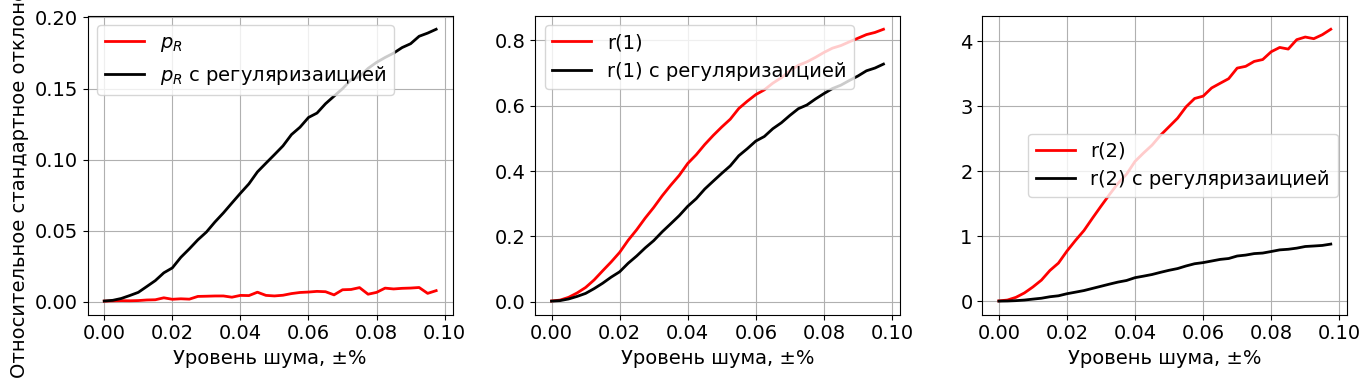

In [51]:
    # Визуализация
    plt.figure(figsize=(14, 4))

    # График давления
    plt.subplot(1, 3, 1)
    plt.plot(noise_list, sco_p_R, label='$p_R$', color='r', lw=2)
    plt.plot(noise_list, regul_sco_p_R, label='$p_R$ с регуляризаицией', color='k', lw=2)
    plt.xlabel('Уровень шума, ±%')
    plt.ylabel('Относительное стандартное отклонение')
    plt.legend()
    plt.grid()


    # График НЧ шума
    plt.subplot(1, 3, 2)
    plt.plot(noise_list, sco_r_1, label='r(1)', color='r', lw=2)
    plt.plot(noise_list, regul_sco_r_1, label='r(1) с регуляризаицией', color='k', lw=2)
    plt.xlabel('Уровень шума, ±%')
    plt.legend()
    plt.grid()

    # График ВЧ шума
    plt.subplot(1, 3, 3)
    plt.plot(noise_list, sco_r_2, label='r(2)', color='r', lw=2)
    plt.plot(noise_list, regul_sco_r_2, label='r(2) с регуляризаицией', color='k', lw=2)
    plt.xlabel('Уровень шума, ±%')
    plt.legend()
    plt.grid()


    plt.tight_layout()
    plt.show()

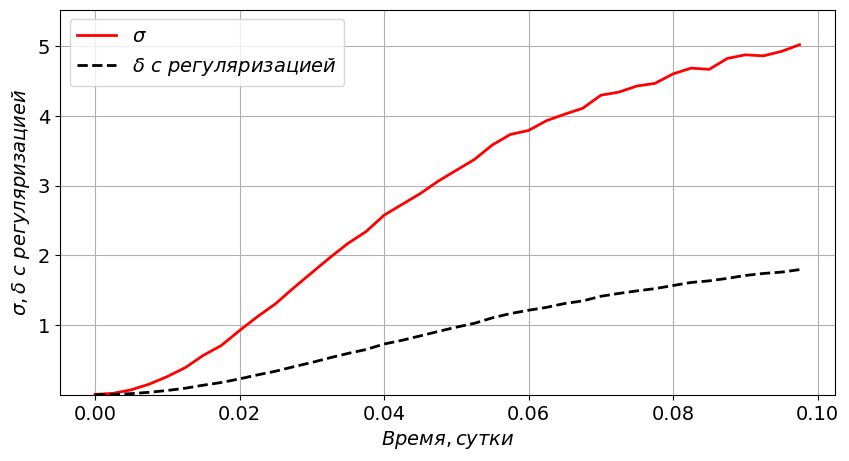

In [52]:

plot_data = [
            {'data': (
              PlotData(pd.Series(sco), 'r', 2, '\sigma'),
              PlotData(pd.Series(regul_sco), 'k--', 2, '\delta\\ с\\ регуляризацией'),
              ), 'x': noise_list, 'dt': 1},
            ]

plot = build_plot(plot_data)
plot.show()

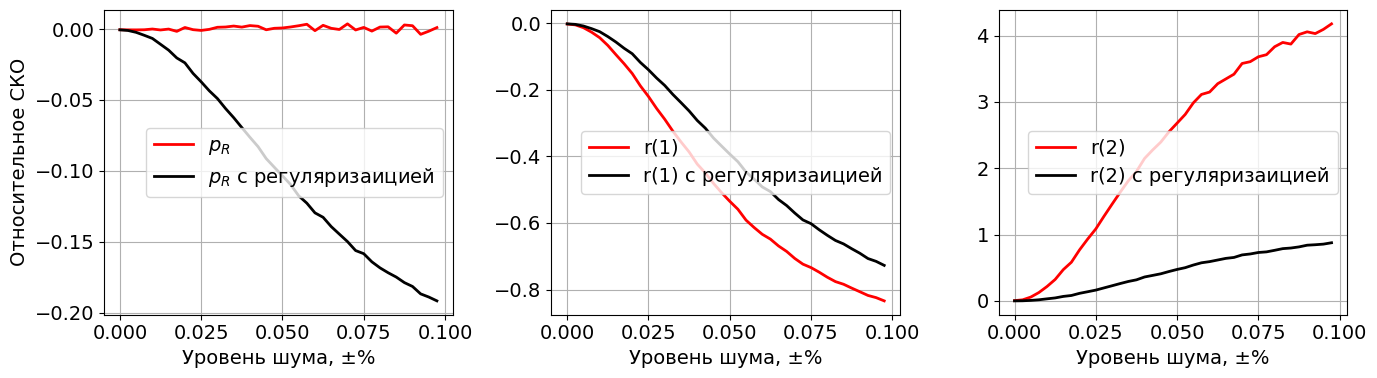

In [54]:
    # Визуализация
    plt.figure(figsize=(14, 4))

    # График давления
    plt.subplot(1, 3, 1)
    plt.plot(noise_list, calc_bias_by_series(res['p_R'][0,0], well.reservoir.p_R), label='$p_R$', color='r', lw=2)
    plt.plot(noise_list, calc_bias_by_series(res_regul['p_R'][0,0], well.reservoir.p_R), label='$p_R$ с регуляризаицией', color='k', lw=2)
    plt.xlabel('Уровень шума, ±%')
    plt.ylabel('Относительное СКО')
    plt.legend()
    plt.grid()

    # График НЧ шума
    plt.subplot(1, 3, 2)
    plt.plot(noise_list, calc_bias_by_series(res['r_1'][0,0], well.reservoir.r_1), label='r(1)', color='r', lw=2)
    plt.plot(noise_list, calc_bias_by_series(res_regul['r_1'][0,0], well.reservoir.r_1), label='r(1) с регуляризаицией', color='k', lw=2)
    plt.xlabel('Уровень шума, ±%')
    plt.legend()
    plt.grid()

    # График ВЧ шума
    plt.subplot(1, 3, 3)
    plt.plot(noise_list, calc_bias_by_series(res['r_2'][0,0], well.reservoir.r_2), label='r(2)', color='r', lw=2)
    plt.plot(noise_list, calc_bias_by_series(res_regul['r_2'][0,0], well.reservoir.r_2), label='r(2) с регуляризаицией', color='k', lw=2)
    plt.xlabel('Уровень шума, ±%')
    plt.legend()
    plt.grid()


    plt.tight_layout()
    plt.show()

In [20]:
#from scipy.ndimage import gaussian_filter
#mse = res['sco']
#MSE_smoothed = gaussian_filter(mse, sigma=1.5)
#
#X, Y = np.meshgrid(denominator_list_minutes,  quant_step_list)
#fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(111, projection='3d')
#ax.view_init(elev=30, azim=30)
#ax.plot_surface(X, Y, MSE_smoothed, cmap='viridis', alpha=0.85)
#ax.set_xlabel('$dt_и$, минут')
#ax.set_ylabel('Квант')
#plt.show()

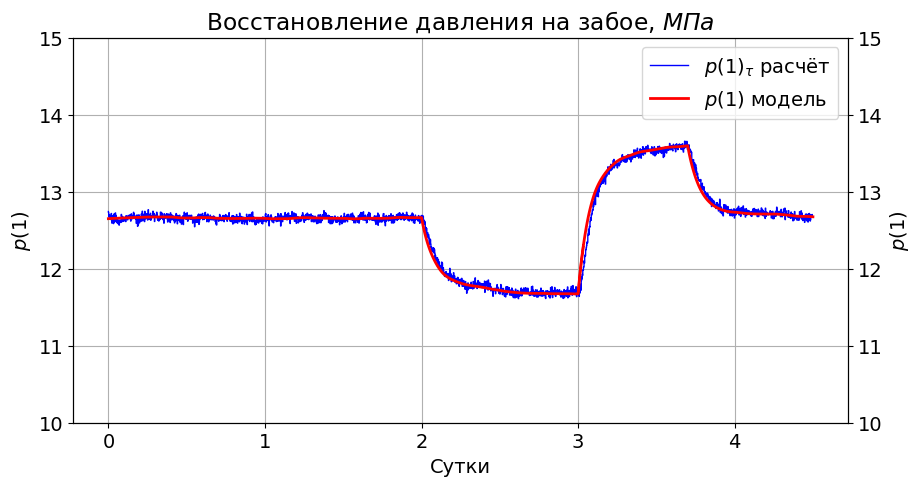

In [21]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p2, = twin1.step(df['x'], df['p_1'], 'r', lw=2, label="$p(1)$ модель")
p1, = ax.step(df_ident['x'], calc_df['p_1_t'], 'b', lw=1, label=r"$p(1)_\tau$ расчёт")


ax.set(ylim=(10, 15), xlabel="Сутки", ylabel="$p(1)$")
twin1.set(ylim=(10, 15), ylabel="$p(1)$")

plt.title('Восстановление давления на забое, $МПа$')

ax.legend(handles=[p1, p2])
ax.grid()
plt.show()



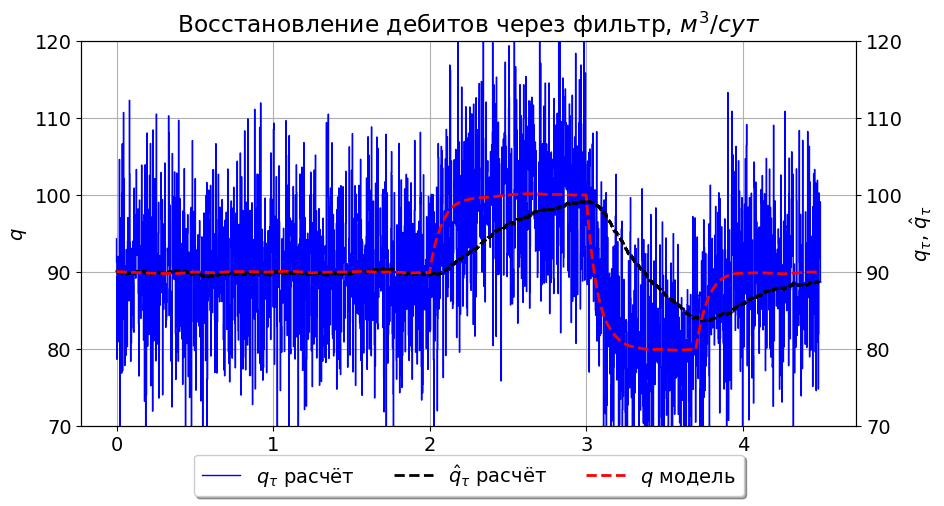

In [22]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.step(df_ident['x'], calc_df['q_t'], 'b', lw=1, label=r"$q_\tau$ расчёт")
p2, = ax.step(df_ident['x'], calc_df['_q_t'], 'k--', lw=2, label=r"$\^{q}_\tau$ расчёт")
p3, = twin1.plot(df['x'], df['q'], 'r--', lw=2, label="$q$ модель")


ax.set(ylim=(70, 120), xlabel="Сутки", ylabel="$q$")
twin1.set(ylim=(70, 120), ylabel=r"$q_\tau$, $\^{q}_\tau$")

plt.title('Восстановление дебитов через фильтр, $м^3/сут$')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, handles=[p1, p2, p3])
ax.grid()
plt.show()

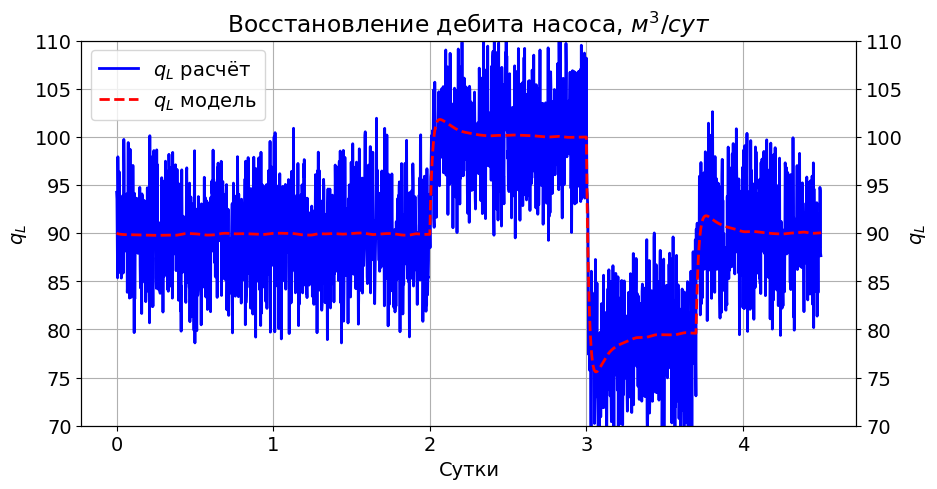

In [23]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.plot(df_ident['x'], calc_df['q_L'], 'b', lw=2, label=r"$q_L$ расчёт")
p2, = ax.plot(df['x'], df['q_L'], 'r--', lw=2, label="$q_L$ модель")

ax.set(ylim=(70, 110), xlabel="Сутки", ylabel="$q_L$")
twin1.set(ylim=(70, 110), ylabel=r"$q_L$")

plt.title('Восстановление дебита насоса, $м^3/сут$')

ax.legend(handles=[p1, p2])
ax.grid()
plt.show()

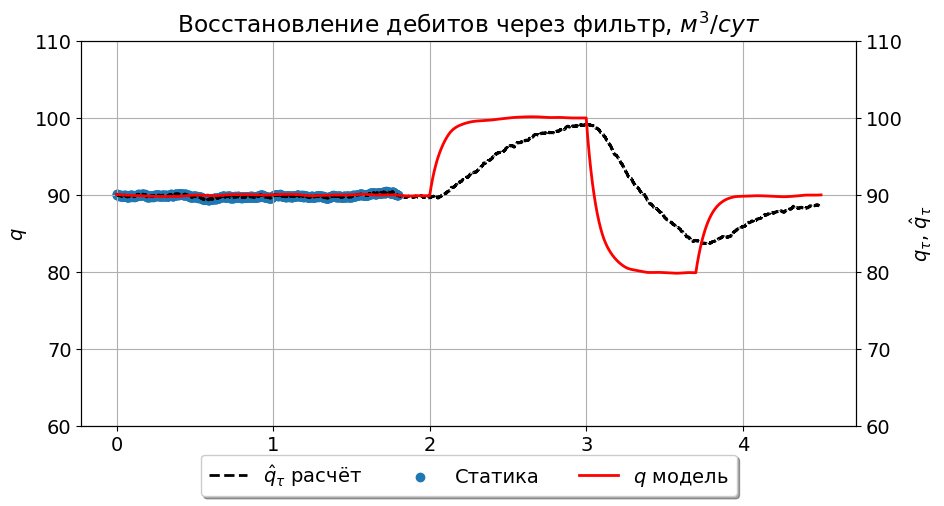

In [24]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

s_time = s_q_t.index * denominator * dt

p1, = ax.step(df_ident['x'], calc_df['_q_t'], 'k--', lw=2, label=r"$\^{q}_\tau$ расчёт")
p2 = ax.scatter(s_time, s_q_t.values, label=r"Статика")
p3, = twin1.plot(df['x'], df['q'], 'r', lw=2, label="$q$ модель")


ax.set(ylim=(60, 110), xlabel="Сутки", ylabel="$q$")
twin1.set(ylim=(60, 110), ylabel=r"$q_\tau$, $\^{q}_\tau$")

plt.title('Восстановление дебитов через фильтр, $м^3/сут$')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, handles=[p1, p2, p3])
ax.grid()
plt.show()